# Deep Dream

## imports

In [257]:
# native libs
import os
import enum
from collections import namedtuple
import argparse
import numbers
import math

# deep learning libs
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch.nn.functional as F
from torch.hub import download_url_to_file

import cv2 as cv # for image processing
import numpy as np # for matrix and vector releated stuffs
import matplotlib.pyplot as plt # visualizations

## Enumns and constans as helpers

In [252]:
# for datasets we will be using
class SupportedPretrainedWeights(enum.Enum):
    IMAGENET = 0
    PLACES_365 = 1
    # we can add more datasets if we want
    
    
# Models architecture names class
class SupportedModels(enum.Enum):
    VGG16_EXPERIMENTAL = 0
    RESNET50 = 1
    # we can add more models architecture if we want in future
    
    
# Commonly used paths, let's define them here as constants
DATA_DIR_PATH = os.path.join(os.getcwd(), "data")
INPUT_DATA_PATH = os.path.join(os.getcwd(), "input")
BINARIES_PATH = os.path.join(os.getcwd(), "models", "binaries")
OUT_IMAGES_PATH = os.path.join(os.getcwd(), "out-images")

# make sure these path exists as the rest of the code relies on it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(OUT_IMAGES_PATH, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # checking whether you have a GPU

# Images will be normalized using these, because the CNNs were trained with normalized images as well
IMAGENET_MEAN_1 = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD_1 = np.array([0.229, 0.224, 0.225], dtype=np.float32)

## Exposing neural network's activations

### Now lets expose the activations coming from the VGG16 as we'll need those later you'll soon understand exactly why

In [143]:
class Vgg16Experimental(torch.nn.Module):
    def __init__(self, pretrained_weights, requires_grad=False, show_progress=False):
        super().__init__()
        
        # only image net weighs are suspported for now for this model
        if pretrained_weights == SupportedPretrainedWeights.IMAGENET.name:
            # eval will turn mode from train to test which tells pytorch to not store grads as we have pretrained weights.
            vgg16 = models.vgg16(pretrained=True, progress=show_progress).eval() 
        else:
            raise Exception(f"{pretrained_weights =} not yet supported for {self.__class__.__name__} model.")
        
        # grab vgg16 convolution layers
        # refer to: https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py
        vgg_pretrained_features = vgg16.features
        
        # The best/most intresting layers in my opinion (mp5 is not that good though)
        self.layer_names = ["relu3_3", "relu4_1", "relu4_2", "relu4_3", "relu5_1", "relu5_2", "relu5_3", "mp5"]
        
        # 31 layers in total for the VGG16
        self.conv1_1 = vgg_pretrained_features[0]
        self.relu1_1 = vgg_pretrained_features[1]
        self.conv1_2 = vgg_pretrained_features[2]
        self.relu1_2 = vgg_pretrained_features[3]
        self.max_pooling1 = vgg_pretrained_features[4]
        self.conv2_1 = vgg_pretrained_features[5]
        self.relu2_1 = vgg_pretrained_features[6]
        self.conv2_2 = vgg_pretrained_features[7]
        self.relu2_2 = vgg_pretrained_features[8]
        self.max_pooling2 = vgg_pretrained_features[9]
        self.conv3_1 = vgg_pretrained_features[10]
        self.relu3_1 = vgg_pretrained_features[11]
        self.conv3_2 = vgg_pretrained_features[12]
        self.relu3_2 = vgg_pretrained_features[13]
        self.conv3_3 = vgg_pretrained_features[14]
        self.relu3_3 = vgg_pretrained_features[15]
        self.max_pooling3 = vgg_pretrained_features[16]
        self.conv4_1 = vgg_pretrained_features[17]
        self.relu4_1 = vgg_pretrained_features[18]
        self.conv4_2 = vgg_pretrained_features[19]
        self.relu4_2 = vgg_pretrained_features[20]
        self.conv4_3 = vgg_pretrained_features[21]
        self.relu4_3 = vgg_pretrained_features[22]
        self.max_pooling4 = vgg_pretrained_features[23]
        self.conv5_1 = vgg_pretrained_features[24]
        self.relu5_1 = vgg_pretrained_features[25]
        self.conv5_2 = vgg_pretrained_features[26]
        self.relu5_2 = vgg_pretrained_features[27]
        self.conv5_3 = vgg_pretrained_features[28]
        self.relu5_3 = vgg_pretrained_features[29]
        self.max_pooling5 = vgg_pretrained_features[30]
        
        # Turning of gradients saving part as we are using pretrained network and don't want to save grads
        if not requires_grad:
            for name, param in self.named_parameters():
                param.requires_grad = False

                
    def forward(self, x):
        x = self.conv1_1(x)
        conv1_1 = x
        x = self.relu1_1(x)
        relu1_1 = x
        x = self.conv1_2(x)
        conv1_2 = x
        x = self.relu1_2(x)
        relu1_2 = x
        x = self.max_pooling1(x)
        x = self.conv2_1(x)
        conv2_1 = x
        x = self.relu2_1(x)
        relu2_1 = x
        x = self.conv2_2(x)
        conv2_2 = x
        x = self.relu2_2(x)
        relu2_2 = x
        x = self.max_pooling2(x)
        x = self.conv3_1(x)
        conv3_1 = x
        x = self.relu3_1(x)
        relu3_1 = x
        x = self.conv3_2(x)
        conv3_2 = x
        x = self.relu3_2(x)
        relu3_2 = x
        x = self.conv3_3(x)
        conv3_3 = x
        x = self.relu3_3(x)
        relu3_3 = x
        x = self.max_pooling3(x)
        x = self.conv4_1(x)
        conv4_1 = x
        x = self.relu4_1(x)
        relu4_1 = x
        x = self.conv4_2(x)
        conv4_2 = x
        x = self.relu4_2(x)
        relu4_2 = x
        x = self.conv4_3(x)
        conv4_3 = x
        x = self.relu4_3(x)
        relu4_3 = x
        x = self.max_pooling4(x)
        x = self.conv5_1(x)
        conv5_1 = x
        x = self.relu5_1(x)
        relu5_1 = x
        x = self.conv5_2(x)
        conv5_2 = x
        x = self.relu5_2(x)
        relu5_2 = x
        x = self.conv5_3(x)
        conv5_3 = x
        x = self.relu5_3(x)
        relu5_3 = x
        mp5 = self.max_pooling5(x)
        
        # Finally expose only the layers that you want to experiment with
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(relu3_3, relu4_1, relu4_2, relu4_3, relu5_1, relu5_2, relu5_3, mp5)
        
        return out
    
    
def fetch_and_prepare_model(model_type: str, pretrained_weights: str):
    """
    Function to return model
    
    parameters:
    model_type (str): Name of the model eg. VGG16_EXPERIMENTAL or RESNET50
    pretrained_weights (str): weights for given dataset eg. IMAGENET
    """
    if model_type == SupportedModels.VGG16_EXPERIMENTAL.name:
        model = Vgg16Experimental(pretrained_weights, requires_grad= False, show_progress=True).to(DEVICE)
    elif model_type == SupportedModels.RESNET50.name:
        model = ResNet50(pretrained_weights, requires_grad= False, show_progress= True).to(DEVICE)
    else:
        raise Exception("Model not yet supported")
        
    return model

### Resnet50

In [266]:
class ResNet50(torch.nn.Module):
    def __init__(self, pretrained_weights, requires_grad=False, show_progress= False):
        super().__init__()
        
        if pretrained_weights == SupportedPretrainedWeights.IMAGENET.name:
            resnet50 = models.resnet50(pretrained=True, progress=show_progress).eval() # test mode
        elif pretrained_weights == SupportedPretrainedWeights.PLACES_365.name:
            resnet50 = models.resnet50(pretrained=False, progress=show_progress).eval()
            
            binary_name = "resnet50_places365.pth.tar"
            resnet50_places365_binary_path = os.path.join(BINARIES_PATH, binary_name)
            
            if os.path.exists(resnet50_places365_binary_path):
                state_dict = torch.load(resnet50_places365_binary_path, map_location=torch.device(DEVICE))['state_dict']
            else:
                binary_url = r'http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar'
                print(f'Downloading {binary_name} from {binary_url} it may take some time.')
                download_url_to_file(binary_url, resnet50_places365_binary_path)
                print('Done downloading.')
                state_dict = torch.load(resnet50_places365_binary_path)['state_dict']
                
            new_state_dict = {} # modify key names and make it compatible with current pytorch model naming scheme
            for old_key in state_dict.keys():
                new_key = old_key[7:]
                new_state_dict[new_key] = state_dict[old_key]
                
            resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 365)
            resnet50.load_state_dict(new_state_dict, strict=True)
        else:
            raise Exception(f"Pretrained weights {pretrained_weights} not yet supported for {self.__class__.__name__} model.")
            
        self.layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
        
        self.conv1 = resnet50.conv1
        self.bn1 = resnet50.bn1
        self.relu = resnet50.relu
        self.maxpool = resnet50.maxpool

        # 3
        self.layer10 = resnet50.layer1[0]
        self.layer11 = resnet50.layer1[1]
        self.layer12 = resnet50.layer1[2]

        # 4
        self.layer20 = resnet50.layer2[0]
        self.layer21 = resnet50.layer2[1]
        self.layer22 = resnet50.layer2[2]
        self.layer23 = resnet50.layer2[3]

        # 6
        self.layer30 = resnet50.layer3[0]
        self.layer31 = resnet50.layer3[1]
        self.layer32 = resnet50.layer3[2]
        self.layer33 = resnet50.layer3[3]
        self.layer34 = resnet50.layer3[4]
        self.layer35 = resnet50.layer3[5]

        # 3
        self.layer40 = resnet50.layer4[0]
        self.layer41 = resnet50.layer4[1]
        # self.layer42 = resnet50.layer4[2]

        # Go even deeper into ResNet's BottleNeck module for layer 42
        self.layer42_conv1 = resnet50.layer4[2].conv1
        self.layer42_bn1 = resnet50.layer4[2].bn1
        self.layer42_conv2 = resnet50.layer4[2].conv2
        self.layer42_bn2 = resnet50.layer4[2].bn2
        self.layer42_conv3 = resnet50.layer4[2].conv3
        self.layer42_bn3 = resnet50.layer4[2].bn3
        self.layer42_relu = resnet50.layer4[2].relu

        # Set these to False so that PyTorch won't be including them in its autograd engine - eating up precious memory
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    # Feel free to experiment with different layers
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer10(x)
        layer10 = x
        x = self.layer11(x)
        layer11 = x
        x = self.layer12(x)
        layer12 = x
        x = self.layer20(x)
        layer20 = x
        x = self.layer21(x)
        layer21 = x
        x = self.layer22(x)
        layer22 = x
        x = self.layer23(x)
        layer23 = x
        x = self.layer30(x)
        layer30 = x
        x = self.layer31(x)
        layer31 = x
        x = self.layer32(x)
        layer32 = x
        x = self.layer33(x)
        layer33 = x
        x = self.layer34(x)
        layer34 = x
        x = self.layer35(x)
        layer35 = x
        x = self.layer40(x)
        layer40 = x
        x = self.layer41(x)
        layer41 = x

        layer42_identity = layer41
        x = self.layer42_conv1(x)
        layer420 = x
        x = self.layer42_bn1(x)
        layer421 = x
        x = self.layer42_relu(x)
        layer422 = x
        x = self.layer42_conv2(x)
        layer423 = x
        x = self.layer42_bn2(x)
        layer424 = x
        x = self.layer42_relu(x)
        layer425 = x
        x = self.layer42_conv3(x)
        layer426 = x
        x = self.layer42_bn3(x)
        layer427 = x
        x += layer42_identity
        layer428 = x
        x = self.relu(x)
        layer429 = x

        # Feel free to experiment with different layers, layer35 is my favourite
        net_outputs = namedtuple("ResNet50Outputs", self.layer_names)
        # You can see the potential ambiguity arising here if we later want to reconstruct images purely from the filename
        out = net_outputs(layer10, layer23, layer34, layer40)
        return out

## Image loading, saving and displaying

### Image utility functions that will handle data (images) loading , saving and plotting!

In [163]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f"Path does not exist: {img_path}")
        
    img = cv.imread(img_path)[:, :, ::-1] # converts BGR(Opencv format) to RGB
    
    if target_shape is not None: # resize section
        if isinstance(target_shape, int) and target_shape != -1: # scaler -> implicitly setting the width
            current_height, current_width = img.shape[:2]
            new_width = target_shape
            new_heigth = int(current_height * (new_width / current_width))
            img = cv.resize(img, (new_width, new_heigth), interpolation=cv.INTER_CUBIC)
        else:
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)
        
    # Normalizing the image as cv.resize will push the values outsize of [0, 1] range
    img = img.astype(np.float32)
    img /= 255.0 # get [0, 1] range
    return img


def save_and_maybe_display_image(config, dump_img, name_modifier=None):
    assert isinstance(dump_img, np.ndarray), f"Expected numpy array got {type(dump_img)}"
    
    # step 1: figure out the dump dir location
    dump_dir = config['dump_dir']
    os.makedirs(dump_dir, exist_ok=True)
    
    # step 2: define the output image name
    if name_modifier is not None:
        dump_img_name = str(name_modifier).zfill(6) + ".jpg"
    else:
        dump_img_name = build_image_name(config)
        
    if dump_img.dtype != np.uint8:
        # converting from float32 to uint8 as when processing image we tend to use image pixels from [0, 1] 
        # but when saving the image we use [0, 255]
        dump_img = (dump_img * 255).astype(np.uint8)
        
    # step 3: write image to the file syste
    # ::-1 because opencv expects BGR (not RGB) format...
    dump_path = os.path.join(dump_dir, dump_img_name)
    cv.imwrite(dump_path, dump_img[:, :, ::-1])
    
    # step 4: potentially display/plot the image
    if config['should_display']:
        fig = plt.figure(figsize=(7.5, 5), dpi=100) # Otherwise plots are really small in jupyter notebook
        plt.imshow(dump_img)
        plt.show()
        
    return dump_path


def build_image_name(config):
    '''
    This function makes sure we can later reconstruct the image using the information encoded into the filename!
    '''
    input_name = "rand_noise" if config["use_noise"] else config["input"].split(".")[0]
    layers = "_".join(config["layers_to_use"])
    img_name = f'{input_name}_width_{config["img_width"]}_model_{config["model_name"]}_{config["pretrained_weights"]}_{layers}_pyrsize_{config["pyramid_size"]}_pyrratio_{config["pyramid_ratio"]}_iter_{config["num_gradient_ascent_iterations"]}_lr_{config["lr"]}_shift_{config["spatial_shift_size"]}_smooth_{config["smoothing_coefficient"]}.jpg'
    return img_name

### Lets plot image to make sure everything is working correctly as we exect

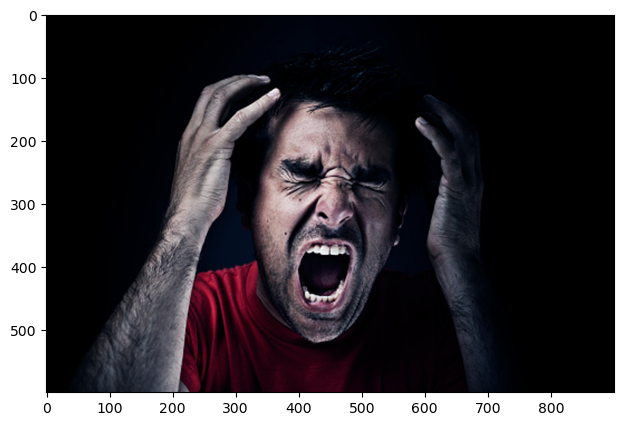

In [145]:
input_img_name = "man.jpg"
img_width = 900
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape=img_width)
fig = plt.figure(figsize=(7.5, 5), dpi=100)
plt.imshow(img)
plt.show()

## Image/tensor utilities

In [146]:
# mean/std normalization - ImageNet's mean and std capture the statistics of natural images pretty nicely.
# This works for Places365 dataset as well (keep in mind you might have to change it if your dataset is way different)
def pre_process_numpy_img(img):
    assert isinstance(img, np.ndarray), f'Expected numpy image got {type(img)}'

    img = (img - IMAGENET_MEAN_1) / IMAGENET_STD_1  # normalize image
    return img


def post_process_numpy_img(img):
    assert isinstance(img, np.ndarray), f'Expected numpy image got {type(img)}'

    if img.shape[0] == 3:  # if channel-first format move to channel-last (CHW -> HWC)
        img = np.moveaxis(img, 0, 2)

    mean = IMAGENET_MEAN_1.reshape(1, 1, -1)
    std = IMAGENET_STD_1.reshape(1, 1, -1)
    img = (img * std) + mean  # de-normalize
    img = np.clip(img, 0., 1.)  # make sure it's in the [0, 1] range

    return img


def pytorch_input_adapter(img):
    # shape = (1, 3, H, W)
    tensor = transforms.ToTensor()(img).to(DEVICE).unsqueeze(0)
    tensor.requires_grad = True  # we need to collect gradients for the input image
    return tensor


def pytorch_output_adapter(tensor):
    # Push to CPU, detach from the computational graph, convert from (1, 3, H, W) tensor into (H, W, 3) numpy image
    return np.moveaxis(tensor.to('cpu').detach().numpy()[0], 0, 2)


# Adds stochasticity to the algorithm and makes the results more diverse
def random_circular_spatial_shift(tensor, h_shift, w_shift, should_undo=False):
    if should_undo:
        h_shift = -h_shift
        w_shift = -w_shift
    with torch.no_grad():
        rolled = torch.roll(tensor, shifts=(h_shift, w_shift), dims=(2, 3))
        rolled.requires_grad = True
        return rolled

## Image Pyramid

In [155]:
def get_new_shape(config, original_shape, current_pyramid_level):
    SHAPE_MARGIN = 10
    pyramid_ratio = config['pyramid_ratio']
    pyramid_size = config['pyramid_size']
    exponent = current_pyramid_level - pyramid_size + 1 # this one will be negative so we're dividing the original img shape
    new_shape = np.round(np.float32(original_shape) * (pyramid_ratio ** exponent)).astype(np.int32)
    
    if new_shape[0] < SHAPE_MARGIN or new_shape[1] < SHAPE_MARGIN:
        print(f'Pyramid size {config["pyramid_size"]} with pyramid ratio {config["pyramid_ratio"]} gives too small pyramid levels with size={new_shape}')
        print(f'Please change the parameters.')
        exit(0)
        
    return new_shape

## Deep Dream core algo

In [156]:
def deep_dream_static_image(config, img=None):
    model = fetch_and_prepare_model(config['model_name'], config['pretrained_weights'])
    
    try:
        layer_ids_to_use = [model.layer_names.index(layer_name) for layer_name in config['layers_to_use']]
    except Exception as e:
        print(e)
        print(f"Invalid layer names {[layer_name for layer_name in config['layers_to_use']]}.")
        print(f"Available layers for model {config['model_name']} are {model.layer_names}")
        return
    
    if img is None: # load either the provided image or start from a pure noise image
        img_path = os.path.join(INPUT_DATA_PATH, config['input'])
        # convert and load numpy range [0, 1] channel-last RGB image
        img = load_image(img_path, target_shape=config['img_width'])
        if config['use_noise']:
            shape = img.shape
            img = np.random.uniform(low=0.0, high=1.0, size=shape).astype(np.float32)
            
    img = pre_process_numpy_img(img)
    original_shape = img.shape[:-1] # save initial height and width
    
    # Note: simply rescaling the whole result (and not only details, see original implementation) gave me better results
    # Going from smaller to bigger resolution (from pyramid top to bottom)
    for pyramid_level in range(config['pyramid_size']):
        new_shape = get_new_shape(config, original_shape, pyramid_level)
        img = cv.resize(img, (new_shape[1], new_shape[0]))  # resize depending on the current pyramid level
        input_tensor = pytorch_input_adapter(img)  # convert to trainable tensor

        for iteration in range(config['num_gradient_ascent_iterations']):
            
            # Introduce some randomness, it will give us more diverse results especially when you're making videos
            h_shift, w_shift = np.random.randint(-config['spatial_shift_size'], config['spatial_shift_size'] + 1, 2)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift)

            
            # This is where the magic happens, treat it as a black box until the next cell
            gradient_ascent(config, model, input_tensor, layer_ids_to_use, iteration)

            # Roll back by the same amount as above (hence should_undo=True)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift, should_undo=True)

        img = pytorch_output_adapter(input_tensor)

    return post_process_numpy_img(img)

## Gradient ascent

In [235]:
LOWER_IMAGE_BOUND = torch.tensor((-IMAGENET_MEAN_1 / IMAGENET_STD_1).reshape(1, -1, 1, 1)).to(DEVICE)
UPPER_IMAGE_BOUND = torch.tensor(((1-IMAGENET_MEAN_1) / IMAGENET_STD_1).reshape(1, -1, 1, 1)).to(DEVICE)

def gradient_ascent(config, model, input_tensor, layer_ids_to_use, iteration):
    # step 0: Feed forward pass
    # Forward will return the activations for the selected layers
    out = model(input_tensor)
    
    # step 1: calculate loss over activations
    activations = [out[layer_id_to_use] for layer_id_to_use in layer_ids_to_use]
    
    # step 2: Calculate loss over activations
    losses = []
    for layer_activation in activations:
        # Use torch.norm(torch.flatten(layer_activation), p) with p=2 for L2 loss and p=1 for L1 loss. 
        # But I'll use the MSE as it works really good, I didn't notice any serious change when going to L1/L2.
        # using torch.zeros_like as if we wanted to make activations as small as possible but we'll do gradient ascent
        # and that will cause it to actually amplify whatever the network "sees" thus yielding the famous DeepDream look
        loss_component = torch.nn.MSELoss(reduction='mean')(layer_activation, torch.zeros_like(layer_activation))
        losses.append(loss_component)
        
    loss = torch.mean(torch.stack(losses))
    loss.backward()
    
    # step 3: Process image gradients (smoothing + normalization), more an art then a science 
    grad = input_tensor.grad.data
    
    # Applies 3 gaussian kernels and thus blurs or smoothens the gradients and gives visually more pleasing results
    # we'll see the details of this one in the next cell and that's all, you understand deep dream
    sigma = ((iteration + 1) / config['num_gradient_ascent_iterations']) * 2.0 + config['smoothing_coefficient']
    smooth_grad = CascadeGaussianSmoothing(kernel_size=9, sigma=sigma)(grad) # "magic number" 9 just works well
    
    # Normalize the gradients (make them have mean=0 and std= 1)
    # I didn't notice any big difference normalizing the mena as well fell free to experiment
    g_std = torch.std(smooth_grad)
    g_mean = torch.mean(smooth_grad)
    smooth_grad = smooth_grad - g_mean
    smooth_grad = smooth_grad / g_std
    
    # step 4: update image using the calculated gradients (ascent step)
    input_tensor.data += config['lr'] * smooth_grad
    
    # step5: clear gradients and clamp the data (otherwise values would explode to +- "infinity")
    input_tensor.grad.data.zero_()
    input_tensor.data = torch.max(torch.min(input_tensor, UPPER_IMAGE_BOUND), LOWER_IMAGE_BOUND)

## Gaussian smoothing

In [218]:
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing seperately for each channel (depthwise convolution)
    
    Arguments:
        kernel_size (int, sequence): size of the gaussian kernel
        sigma (float, sequence): Standard deviation of the gaussian kernel
    """
    def __init__(self, kernel_size, sigma):
        super().__init__()

        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size, kernel_size]

        cascade_coefficients = [0.5, 1.0, 2.0]  # std multipliers, hardcoded to use 3 different Gaussian kernels
        sigmas = [[coeff * sigma, coeff * sigma] for coeff in cascade_coefficients]  # isotropic Gaussian

        self.pad = int(kernel_size[0] / 2)  # assure we have the same spatial resolution

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)
            kernel = kernel.to(DEVICE)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad, self.pad, self.pad], mode='reflect')

        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

What it does is it creates three **9x9 Gaussian kernels** and it applies them, **depthwise**, over the input gradients.

Kernel 1 is applied to channels 1, 2 and 3 and it preserves the shape i.e. we go from (1, 3, H, W) to (1, 3, H, W). <br/>
Similarly for kernels 2 and 3 and then we just combine the output by taking a mean.

---

## inputs argumensts

In [241]:
# Only a small subset is exposed by design to avoid cluttering
parser = argparse.ArgumentParser()

# Common params
parser.add_argument("--input", type=str, help="Input IMAGE or VIDEO name that will be used for dreaming", default='man.jpg')
parser.add_argument("--img_width", type=int, help="Resize input image to this width", default=600)
parser.add_argument("--layers_to_use", type=str, nargs='+', help="Layer whose activations we should maximize while dreaming", default=['relu4_3'])
parser.add_argument("--model_name", choices=[m.name for m in SupportedModels],
                    help="Neural network (model) to use for dreaming", default=SupportedModels.VGG16_EXPERIMENTAL.name)
parser.add_argument("--pretrained_weights", choices=[pw.name for pw in SupportedPretrainedWeights],
                    help="Pretrained weights to use for the above model", default=SupportedPretrainedWeights.IMAGENET.name)

# Main params for experimentation (especially pyramid_size and pyramid_ratio)
parser.add_argument("--pyramid_size", type=int, help="Number of images in an image pyramid", default=4)
parser.add_argument("--pyramid_ratio", type=float, help="Ratio of image sizes in the pyramid", default=1.8)
parser.add_argument("--num_gradient_ascent_iterations", type=int, help="Number of gradient ascent iterations", default=10)
parser.add_argument("--lr", type=float, help="Learning rate i.e. step size in gradient ascent", default=0.09)

# You usually won't need to change these as often
parser.add_argument("--should_display", type=bool, help="Display intermediate dreaming results", default=False)
parser.add_argument("--spatial_shift_size", type=int, help='Number of pixels to randomly shift image before grad ascent', default=32)
parser.add_argument("--smoothing_coefficient", type=float, help='Directly controls standard deviation for gradient smoothing', default=0.5)
parser.add_argument("--use_noise", type=bool, help="Use noise as a starting point instead of input image", default=False)
args = parser.parse_args('')  # important to put '' in Jupyter otherwise it will complain

# Wrapping configuration into a dictionary
config = dict()
for arg in vars(args):
    config[arg] = getattr(args, arg)
config['dump_dir'] = os.path.join(OUT_IMAGES_PATH, f'{config["model_name"]}_{config["pretrained_weights"]}')
config['input'] = os.path.basename(config['input'])  # handle absolute and relative paths

## Run Deep Dream

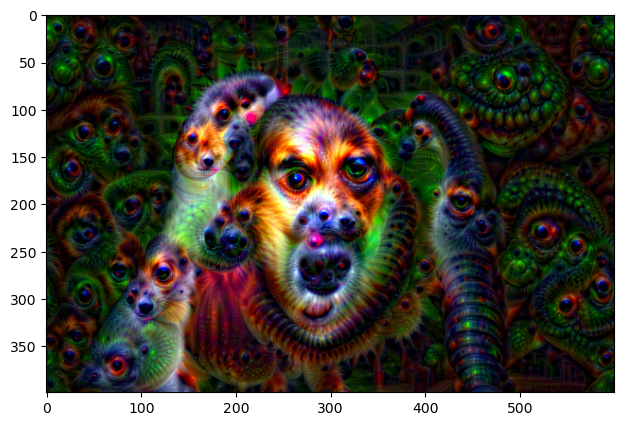

Saving deep dream static img to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg



In [242]:
img = deep_dream_static_image(config)

config['should_display'] = True
dump_path = save_and_maybe_display_image(config, img)
print(f"Saving deep dream static img to: {os.path.relpath(dump_path)}\n")

## Part 2: Experimenting with static DeepDream images

### Setting 1: Use noise

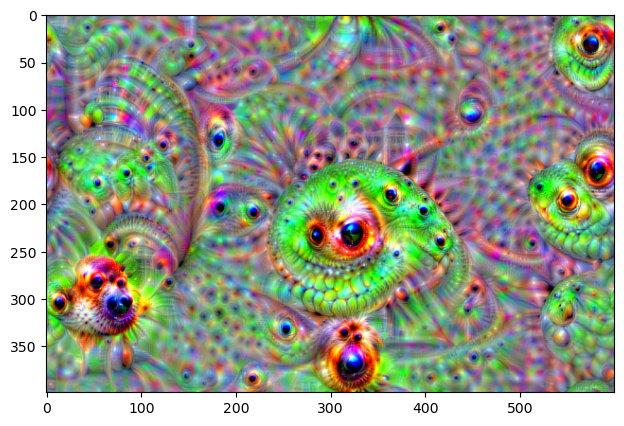

Saved Deep Dream static image to : out-images/VGG16_EXPERIMENTAL_IMAGENET/rand_noise_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg


In [243]:
config['use_noise'] = True
img = deep_dream_static_image(config)
dump_path = save_and_maybe_display_image(config, img)
print(f"Saved Deep Dream static image to : {os.path.relpath(dump_path)}")
config['use_noise'] = False

### Setting 2: layer_to_use

So far we were using **relu4_3** layer.

Based on which layer you choose you'll amplify higher or lower image level features and everything in between. We can also use combinations of layers but it quickly explodes.

exposed_layers =['relu3_3', 'relu4_1', 'relu4_2', 'relu4_3', 'relu5_1']
==== relu3_3output ====


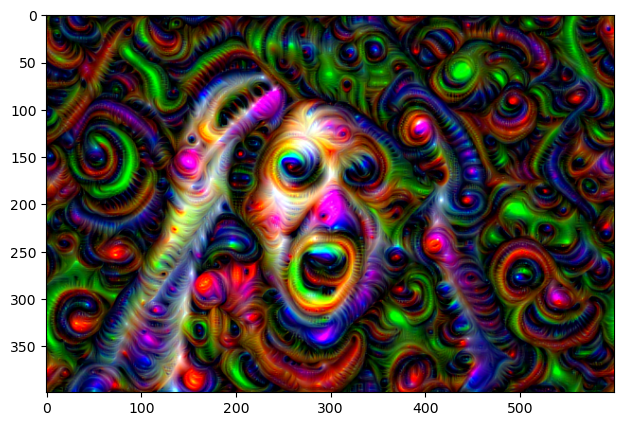

Saved deep dream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu3_3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg
==== relu4_1output ====


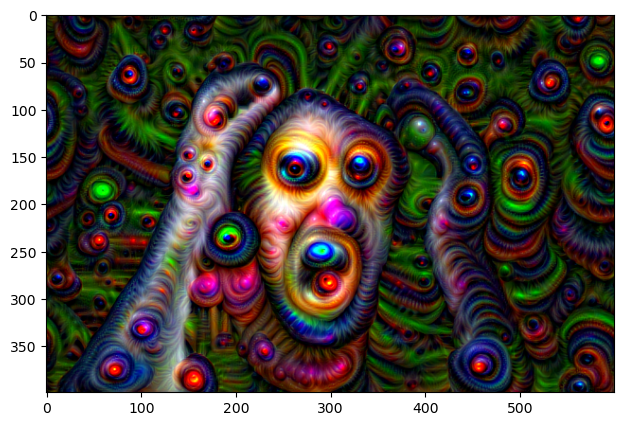

Saved deep dream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_1_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg
==== relu4_2output ====


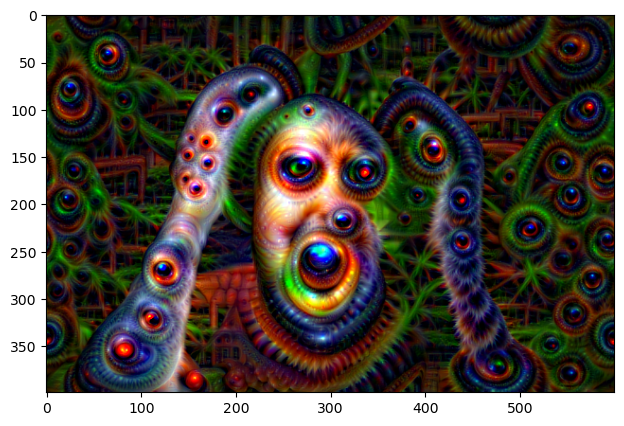

Saved deep dream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_2_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg
==== relu4_3output ====


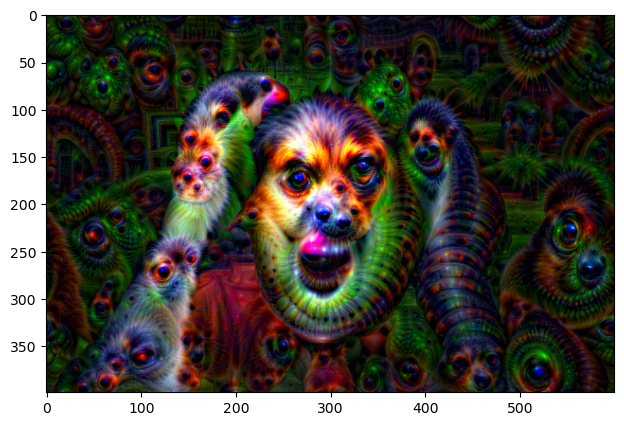

Saved deep dream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg
==== relu5_1output ====


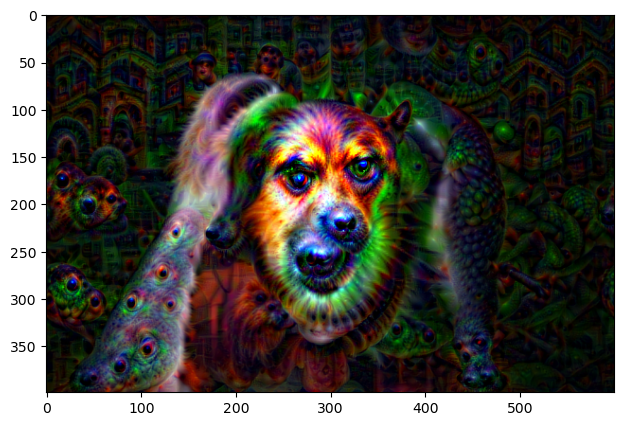

Saved deep dream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu5_1_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg


In [246]:
exposed_layers = Vgg16Experimental(pretrained_weights=SupportedPretrainedWeights.IMAGENET.name).layer_names
exposed_layers = exposed_layers[:-3] 
print(f"{exposed_layers =}")

for layer in exposed_layers:
    print("="*4 + " " + layer + "output " + "="*4)
    config['layers_to_use'] = [layer]
    
    img = deep_dream_static_image(config)
    dump_path = save_and_maybe_display_image(config, img)
    print(f"Saved deep dream static image to: {os.path.relpath(dump_path)}")
    
    
config['layers_to_use'] = ['relu4_3']

### Setting 3: pyramid_size and pyramid_ratio

==== pyramid_size = 1 ====


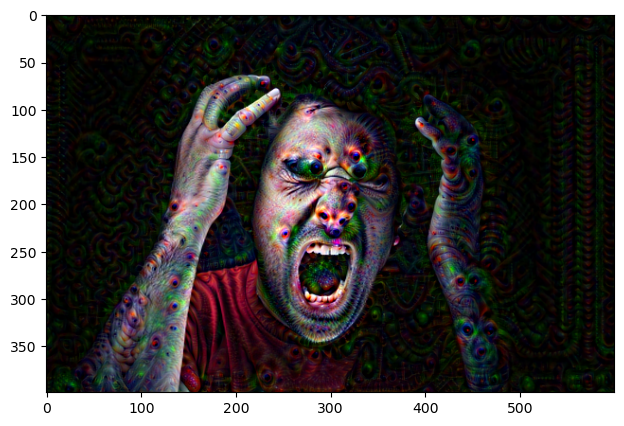

Saved DeepDream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_1_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg
==== pyramid_size = 3 ====


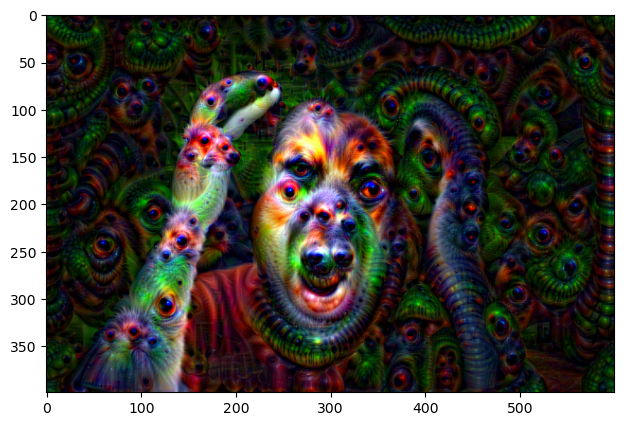

Saved DeepDream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_3_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg
==== pyramid_size = 5 ====


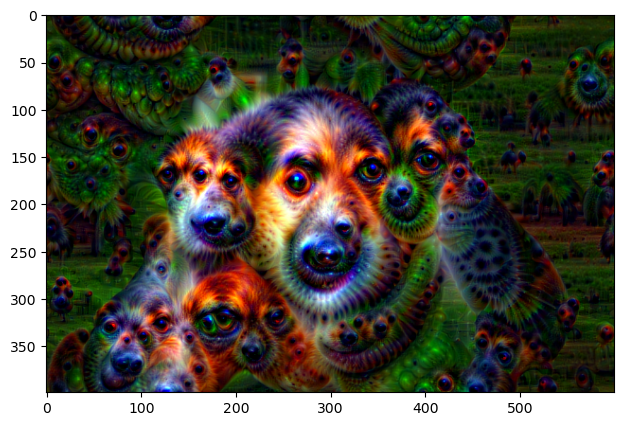

Saved DeepDream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_5_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg


In [248]:
pyramid_sizes = [1, 3, 5]
config['pyramid_ratio'] = 1.8

for pyramid_size in pyramid_sizes:
    print("="*4 + f" {pyramid_size = } " + "="*4)
    config['pyramid_size'] = pyramid_size
    img = deep_dream_static_image(config)
    dump_path = save_and_maybe_display_image(config, img)
    print(f"Saved DeepDream static image to: {os.path.relpath(dump_path)}")
    
config['pyramid_size'] = 4

### Setting 4: num_gradient_ascent_iterations and lr


These 2 have, in a way similar effect. The higher the number the more amplification you'll get.

==== num_iter = 2; lr = 0.09 ====


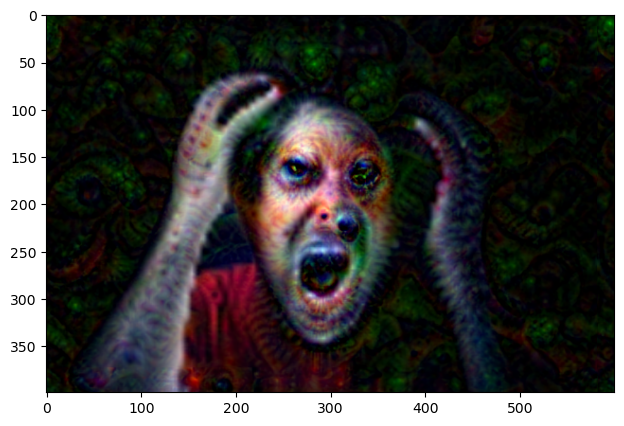

Saved DeepDream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_4_pyrratio_1.8_iter_2_lr_0.09_shift_32_smooth_0.5.jpg
==== num_iter = 5; lr = 0.09 ====


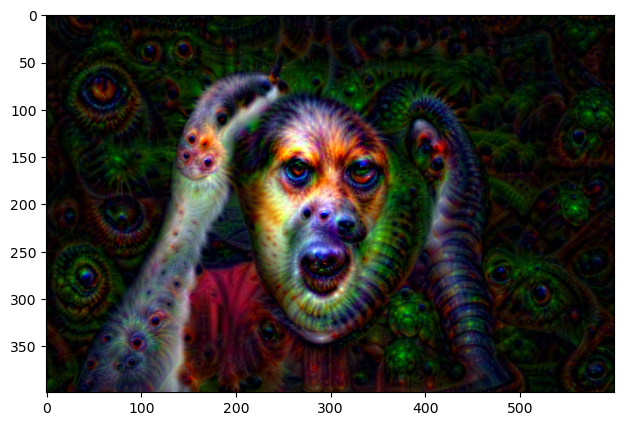

Saved DeepDream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_4_pyrratio_1.8_iter_5_lr_0.09_shift_32_smooth_0.5.jpg
==== num_iter = 20; lr = 0.09 ====


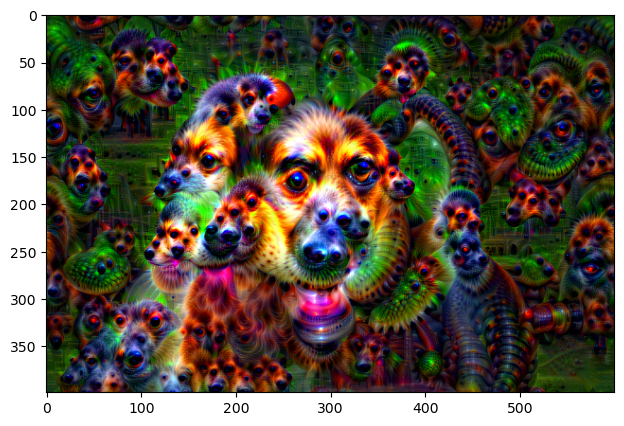

Saved DeepDream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_4_pyrratio_1.8_iter_20_lr_0.09_shift_32_smooth_0.5.jpg


In [251]:
num_gradient_ascent_iterations = [2, 5, 20]
config['lr'] = 0.09 # feel free to play with this one as well

for num_iter in num_gradient_ascent_iterations:
    print("="*4 + f" {num_iter = }; lr = {config['lr']} " + "="*4)
    config['num_gradient_ascent_iterations'] = num_iter
    
    img = deep_dream_static_image(config)
    dump_path = save_and_maybe_display_image(config, img)
    print(f"Saved DeepDream static image to: {os.path.relpath(dump_path)}")
    
config['num_gradient_ascent_iterations'] = 10

## Resnet50 pretrained on Places365 dataset

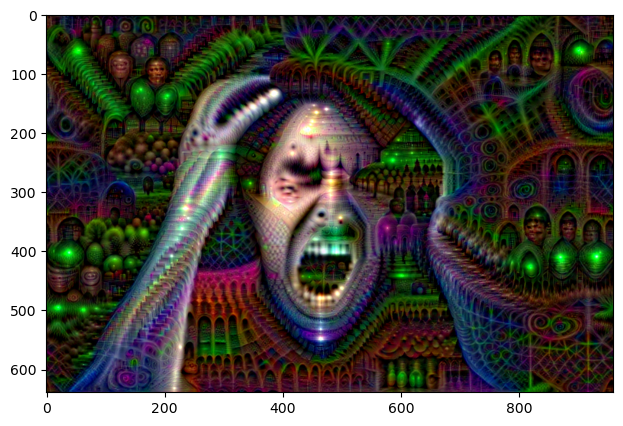

Saved DeepDream static image to: out-images/VGG16_EXPERIMENTAL_IMAGENET/man_width_960_model_RESNET50_PLACES_365_layer3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_40_smooth_0.5.jpg



In [268]:
config['input'] = 'man.jpg'
config['img_width'] = 960
config['model_name'] = SupportedModels.RESNET50.name
config['pretrained_weights'] = SupportedPretrainedWeights.PLACES_365.name
config['layers_to_use'] = ['layer3']  # layer34 was used
config['pyramid_size'] = 4
config['pyramid_ratio'] = 1.8
config['num_gradient_ascent_iterations'] = 10
config['lr'] = 0.09
config['spatial_shift_size'] = 40

img = deep_dream_static_image(config)
dump_path = save_and_maybe_display_image(config, img)
print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')